# Amortization

Functions to generate an amortization table, charts to explore. Primarily focusing on the difference between US mortgages using traditional monthly payment versus a "biweekly" payment structure (paying half of the monthly mortgage every two weeks).

In [1]:
# imports and preliminary functions

import pandas as pd
from datetime import date

def periodic_interest_rate(i, n):
    """periodic interest rate is the annual interest rate divided by the number of compounding periods
    pir = periodic interest rate
    i = annual interest rate (nominal interest rate)
    n = number of compounding periods per year (compounding frequency)
    """
    pir = i/n
    return pir

def periodic_payment_amount(P, pir, n, y):
    """the periodic payment amount is the total amount owed (principal + interest) per compounding period
    ppa = periodic payment amount
    P = initial Principal (loan amount)
    pir = periodic interest rate
    n = compounding periods per year
    y = length of loan in years
    """
    ppa = P * (pir*(1+pir)**(n*y)) / (((1+pir)**(n*y))-1)
    return ppa


In [2]:
def amortization_table(nominal_interest_rate, years, compounding_frequency, payment_frequency, principal, start_date):
    """generates the complete amortization table for the duration of the loan
    df = the final amortization table
    nominal_interest_rate = yearly interest rate of loan
    years = number of years of the loan
    compounding_frequency = compounding periods per year
    payment_frequency = payment periods per year (monthly = 12, "biweekly" = 26)
    principal = initial loan amaount
    start_date = first day of the loan in date(YYYY,MM,D) format
    """
    pir = periodic_interest_rate(i=nominal_interest_rate, n=compounding_frequency)

    # getting compounding period dates for the length of the loan - monthly for American mortgages
    compounding_date_range = pd.date_range(start=start_date, periods=years * compounding_frequency, freq='MS')

    # set up the df with compounding dates as index
    df = pd.DataFrame(index=compounding_date_range,
                      columns=['Payments_per_Period', 'Principal', 'Additional_Principal', 'Interest',
                               'Total_Payment_Due', 'Balance_In', 'Balance_Out'],
                      dtype='float')
    df.reset_index(names='Compound_Date', inplace=True)
    df.index += 1

    # getting payment period dates for the length of the loan
    # we may have a regular pay schedule that differs from the compounding schedule (e.g. biweekly payment vs monthly compounding)
    # find the day of the week of the first day of the loan
    first_day_integer = start_date.weekday()  # 0=Monday, 1=Tuesday, etc
    weekdays_dict = {0: 'MON', 1: 'TUE', 2: 'WED', 3: 'THU', 4: 'FRI', 5: 'SAT', 6: 'SUN'}
    first_day_name = weekdays_dict[first_day_integer]
    # declare the frequency variable for the date_range function depending on payment frequency and day of week
    if payment_frequency == 12:
        frequency_variable = 'MS'
    elif payment_frequency == 26:
        frequency_variable = f"2W-{first_day_name}"
    else:
        frequency_variable = None
    payment_date_range = pd.date_range(start=start_date, periods=years * payment_frequency, freq=frequency_variable)

    dates_df = pd.DataFrame(columns=['pay_date', 'compound_period'],
                            dtype='float')
    dates_df['pay_date'] = payment_date_range
    dates_df['compound_period'] = payment_date_range.to_period('M')

    # how many biweekly payments happen in each month
    payments_per_period_list = list(dates_df.groupby('compound_period').count()['pay_date'])
    # manually input the last month because the biweekly payment ends before 2053-10-01 (won't matter anyway)
    if payment_frequency == 26:
        payments_per_period_list.append(2)
    else:
        pass

    # add Payments_Per_Period
    df['Payments_per_Period'] = payments_per_period_list

    # inputting the periodic total monthly payment (what you owe each month, not including an additional you pay)
    periodic_total_payment = periodic_payment_amount(P=principal, pir=pir, n=compounding_frequency,
                                                     y=years)
    df['Total_Payment_Due'] = periodic_total_payment

    # add Additional Principal based on if there is an extra payment per period
    df.loc[df['Payments_per_Period'] == 3, 'Additional_Principal'] = periodic_total_payment * payment_frequency / 52
    df.fillna({'Additional_Principal': 0}, inplace=True)

    # fill in the first row
    df.loc[1, 'Balance_In'] = principal
    df.loc[1, 'Interest'] = pir * df.loc[1, 'Balance_In']
    df.loc[1, 'Principal'] = df.loc[1, 'Total_Payment_Due'] - df.loc[1, 'Interest']
    df.loc[1, 'Balance_Out'] = df.loc[1, 'Balance_In'] - df.loc[1, 'Principal'] - df.loc[1, 'Additional_Principal']
    new_balance = df.loc[1, 'Balance_Out']  # this value is needed to run the subsequent loop

    for index, row in df.iloc[1:].iterrows():
        df.loc[index, 'Balance_In'] = new_balance
        df.loc[index, 'Interest'] = pir * df.loc[index, 'Balance_In']
        df.loc[index, 'Principal'] = df.loc[index, 'Total_Payment_Due'] - df.loc[index, 'Interest']
        df.loc[index, 'Balance_Out'] = df.loc[index, 'Balance_In'] - df.loc[index, 'Principal'] - df.loc[index, 'Additional_Principal']
        new_balance = df.loc[index, 'Balance_Out']

    # find where the Balance_Out goes negative, end the df there, make sure the last payment adds up
    if payment_frequency == 26:
        last_payment_row = df.query("Balance_Out <= 0")["Balance_Out"].idxmax(skipna=True)
        df = df.loc[0:last_payment_row].copy()
        # make sure the last principal payment isn't too much (could also use df.loc[len(df), 'Principal] eg)
        df.iloc[-1, df.columns.get_loc("Principal")] = df.iloc[-1, df.columns.get_loc("Principal")] + df.iloc[-1, df.columns.get_loc("Balance_Out")]
        df.iloc[-1, df.columns.get_loc("Balance_Out")] = 0
        df.iloc[-1, df.columns.get_loc("Total_Payment_Due")] = df.iloc[-1, df.columns.get_loc("Balance_In")] + df.iloc[-1, df.columns.get_loc("Interest")]
        # this isn't exactly right but whatever
    else:
        pass


    # remove some variables?

    return df

In [3]:
# generate amortization tables for monthly and biweekly payments of an American monthly compounding mortgage
monthly = amortization_table(.0725, 30, 12, 12, 462000, date(2023,11,1))
biweekly = amortization_table(.0725, 30, 12, 26, 462000, date(2023,11,1))

#round the dataframes for clarity
monthly = monthly.round(2).copy()
biweekly = biweekly.round(2).copy()

In [4]:
monthly.head()

,Compound_Date,Payments_per_Period,Principal,Additional_Principal,Interest,Total_Payment_Due,Balance_In,Balance_Out
1,2023-11-01,1,360.40,0.0,2791.25,3151.65,462000.00,461639.60
2,2023-12-01,1,362.58,0.0,2789.07,3151.65,461639.60,461277.01
3,2024-01-01,1,364.77,0.0,2786.88,3151.65,461277.01,460912.24
4,2024-02-01,1,366.98,0.0,2784.68,3151.65,460912.24,460545.26
5,2024-03-01,1,369.19,0.0,2782.46,3151.65,460545.26,460176.07


In [5]:
biweekly.head()

,Compound_Date,Payments_per_Period,Principal,Additional_Principal,Interest,Total_Payment_Due,Balance_In,Balance_Out
1,2023-11-01,3,360.40,1575.83,2791.25,3151.65,462000.00,460063.77
2,2023-12-01,2,372.10,0.00,2779.55,3151.65,460063.77,459691.67
3,2024-01-01,2,374.35,0.00,2777.30,3151.65,459691.67,459317.32
4,2024-02-01,2,376.61,0.00,2775.04,3151.65,459317.32,458940.70
5,2024-03-01,2,378.89,0.00,2772.77,3151.65,458940.70,458561.82


In [6]:
monthly.tail()

,Compound_Date,Payments_per_Period,Principal,Additional_Principal,Interest,Total_Payment_Due,Balance_In,Balance_Out
356,2053-06-01,1,3058.15,0.0,93.50,3151.65,15476.63,12418.48
357,2053-07-01,1,3076.63,0.0,75.03,3151.65,12418.48,9341.86
358,2053-08-01,1,3095.21,0.0,56.44,3151.65,9341.86,6246.64
359,2053-09-01,1,3113.91,0.0,37.74,3151.65,6246.64,3132.73
360,2053-10-01,1,3132.73,0.0,18.93,3151.65,3132.73,0.00


In [7]:
biweekly.tail()

,Compound_Date,Payments_per_Period,Principal,Additional_Principal,Interest,Total_Payment_Due,Balance_In,Balance_Out
275,2046-09-01,2,3053.15,0.00,98.51,3151.65,16304.95,13251.81
276,2046-10-01,3,3071.59,1575.83,80.06,3151.65,13251.81,8604.39
277,2046-11-01,2,3099.67,0.00,51.98,3151.65,8604.39,5504.72
278,2046-12-01,2,3118.40,0.00,33.26,3151.65,5504.72,2386.32
279,2047-01-01,2,2386.32,0.00,14.42,2400.74,2386.32,0.00


### Visualizations of amortization tables



In [8]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np

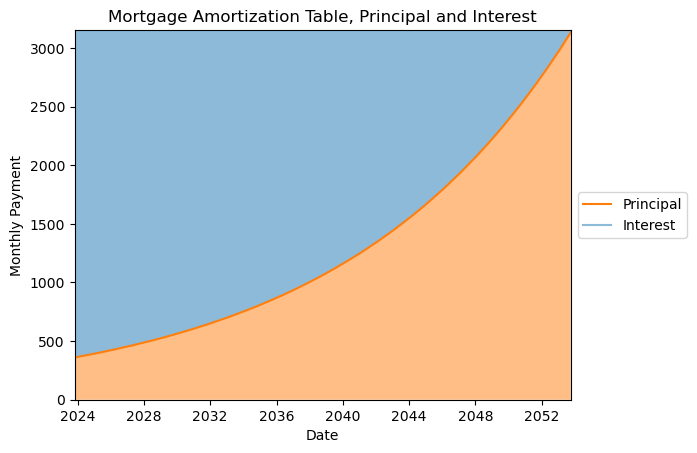

In [9]:
#create the standard lineplot with shading
plt.plot(monthly['Compound_Date'], monthly['Principal'], color='tab:orange')
plt.plot(monthly['Compound_Date'], monthly['Total_Payment_Due'], color='tab:blue', alpha=0.5)
plt.fill_between(monthly['Compound_Date'], monthly['Principal'], monthly['Total_Payment_Due'], alpha=0.5)
plt.fill_between(monthly['Compound_Date'], 0, monthly['Principal'], alpha=0.5)
plt.xlim(monthly.loc[monthly['Compound_Date'].idxmin()]['Compound_Date'], monthly.loc[monthly['Compound_Date'].idxmax()]['Compound_Date'])
plt.ylim(0,monthly.loc[monthly['Total_Payment_Due'].idxmax()]['Total_Payment_Due'])
plt.xlabel('Date')
plt.ylabel("Monthly Payment")
plt.title('Mortgage Amortization Table, Principal and Interest')
plt.legend(['Principal', 'Interest'], loc='center left', bbox_to_anchor = (1,.5))
plt.show()

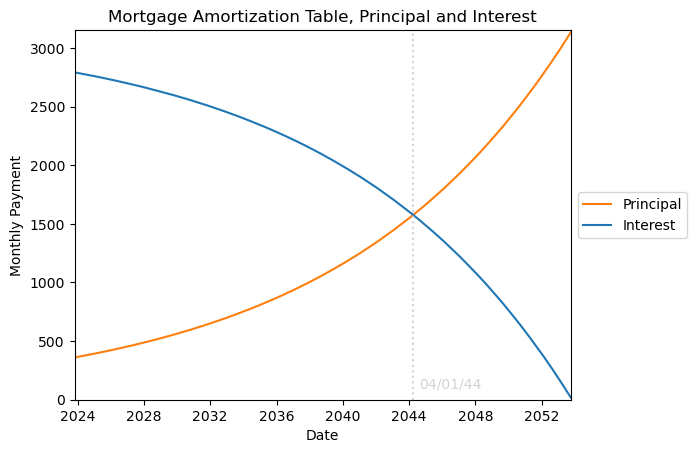

In [10]:
#lineplot with lines for the principal and interest and noting where they cross
plt.plot(monthly['Compound_Date'], monthly['Principal'], color='tab:orange')
plt.plot(monthly['Compound_Date'], monthly['Interest'], color='tab:blue')
plt.axvline(monthly.loc[monthly.query("Principal > Interest")['Compound_Date'].idxmin(skipna=True), 'Compound_Date'],
            color='lightgrey',
            linestyle=':')
plt.annotate(text=monthly.loc[monthly.query("Principal > Interest")['Compound_Date'].idxmin(skipna=True), 'Compound_Date'].strftime("%x"),
             xy=[monthly.loc[monthly.query("Principal > Interest")['Compound_Date'].idxmin(skipna=True) + 4, 'Compound_Date'], 100],
             color='lightgrey')
plt.xlim(monthly.loc[monthly['Compound_Date'].idxmin()]['Compound_Date'], monthly.loc[monthly['Compound_Date'].idxmax()]['Compound_Date'])
plt.ylim(0,monthly.loc[monthly['Total_Payment_Due'].idxmax()]['Total_Payment_Due'])
plt.xlabel('Date')
plt.ylabel("Monthly Payment")
plt.title('Mortgage Amortization Table, Principal and Interest')
plt.legend(['Principal', 'Interest'], loc='center left', bbox_to_anchor = (1,.5))
plt.show()
#need to do with background color (do fig, ax)

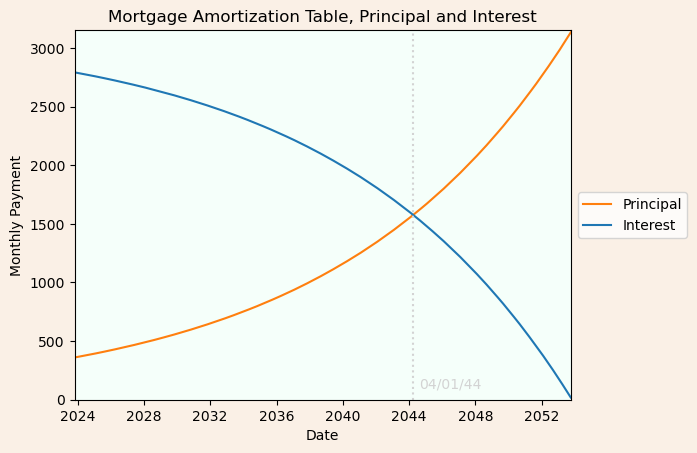

In [11]:
#replicating above with fig, ax so you can do background colors
fig, ax = plt.subplots(facecolor=('linen'))
plt.plot(monthly['Compound_Date'], monthly['Principal'], color='tab:orange')
plt.plot(monthly['Compound_Date'], monthly['Interest'], color='tab:blue')
plt.axvline(monthly.loc[monthly.query("Principal > Interest")['Compound_Date'].idxmin(skipna=True), 'Compound_Date'],
            color='lightgrey',
            linestyle=':')
plt.annotate(text=monthly.loc[monthly.query("Principal > Interest")['Compound_Date'].idxmin(skipna=True), 'Compound_Date'].strftime("%x"),
             xy=[monthly.loc[monthly.query("Principal > Interest")['Compound_Date'].idxmin(skipna=True) + 4, 'Compound_Date'], 100],
             color='lightgrey')
ax.set_facecolor('mintcream')
plt.xlim(monthly.loc[monthly['Compound_Date'].idxmin()]['Compound_Date'], monthly.loc[monthly['Compound_Date'].idxmax()]['Compound_Date'])
plt.ylim(0,monthly.loc[monthly['Total_Payment_Due'].idxmax()]['Total_Payment_Due'])
plt.xlabel('Date')
plt.ylabel("Monthly Payment")
plt.title('Mortgage Amortization Table, Principal and Interest')
plt.legend(['Principal', 'Interest'], loc='center left', bbox_to_anchor = (1,.5))
plt.show()


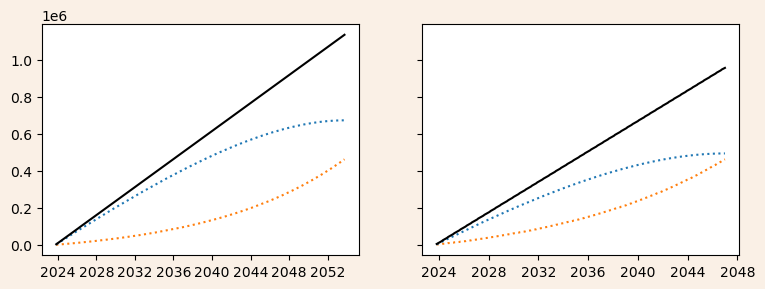

In [12]:
#make an image with both linecharts next to each other
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, facecolor='linen')
ax1.plot(monthly['Compound_Date'], np.cumsum(monthly['Principal']), color='tab:orange', linestyle='dotted')
ax1.plot(monthly['Compound_Date'], np.cumsum(monthly['Interest']), color='tab:blue', linestyle='dotted')
ax1.plot(monthly['Compound_Date'], np.cumsum(monthly['Total_Payment_Due']), color='black')
ax2.plot(biweekly['Compound_Date'], np.cumsum(biweekly['Principal'] + biweekly['Additional_Principal']), color='tab:orange', linestyle='dotted')
ax2.plot(biweekly['Compound_Date'], np.cumsum(biweekly['Interest']), color='tab:blue', linestyle='dotted')
ax2.plot(biweekly['Compound_Date'], np.cumsum(biweekly['Total_Payment_Due'] + biweekly['Additional_Principal']), color='black')

f.set_size_inches(9,3)

plt.show()
#add labels

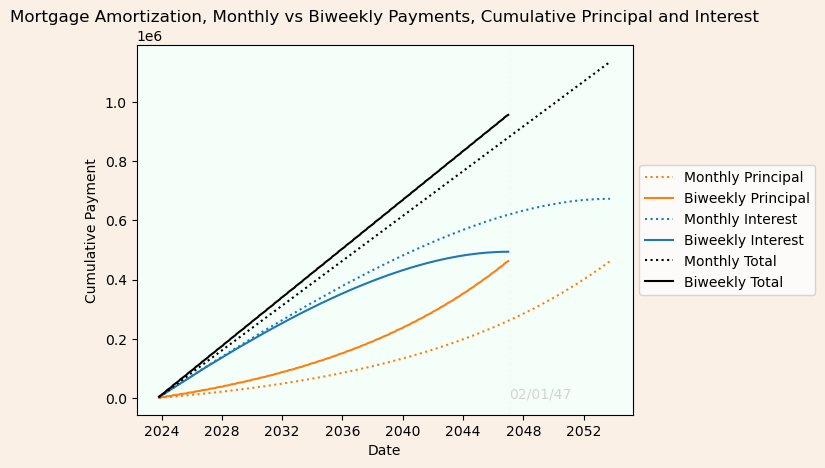

In [13]:
#make a chart with both types of data in one, have to merge dfs first
merged_df = monthly.merge(biweekly, on="Compound_Date", how="left")
merged_df = merged_df[['Compound_Date', 'Principal_x', 'Additional_Principal_x', 'Interest_x', 'Principal_y', 'Additional_Principal_y', 'Interest_y']].copy()
#merged_df.fillna(0, inplace=True)

fig, ax = plt.subplots(facecolor='linen')
plt.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_x'] + merged_df['Additional_Principal_x']), color='tab:orange', linestyle='dotted')
plt.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_y'] + merged_df['Additional_Principal_y']), color='tab:orange')
plt.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Interest_x']), color='tab:blue', linestyle='dotted')
plt.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Interest_y']), color='tab:blue')
plt.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_x'] + merged_df['Additional_Principal_x'] + merged_df['Interest_x']), color='black', linestyle='dotted')
plt.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_y'] + merged_df['Additional_Principal_y'] + merged_df['Interest_y']), color='black')
ax.set_facecolor('mintcream')
plt.axvline(merged_df.loc[merged_df['Principal_y'].isnull().idxmax(), 'Compound_Date'], color='lightgrey', linestyle=':', alpha=.1)
plt.annotate(text=merged_df.loc[merged_df['Principal_y'].isnull().idxmax(), 'Compound_Date'].strftime("%x"),
             xy=[merged_df.loc[merged_df['Principal_y'].isnull().idxmax(), 'Compound_Date'], 100], #i don't think this will work right at full size
             color='lightgrey')
plt.xlabel('Date')
plt.ylabel('Cumulative Payment')
plt.title('Mortgage Amortization, Monthly vs Biweekly Payments, Cumulative Principal and Interest')
ax.legend(['Monthly Principal', 'Biweekly Principal', 'Monthly Interest', 'Biweekly Interest', 'Monthly Total', 'Biweekly Total'], loc='center left', bbox_to_anchor = (1,.5))
plt.show()
#maybe want to change color scheme, add xlim and ylim, and add labels to the end of the liens

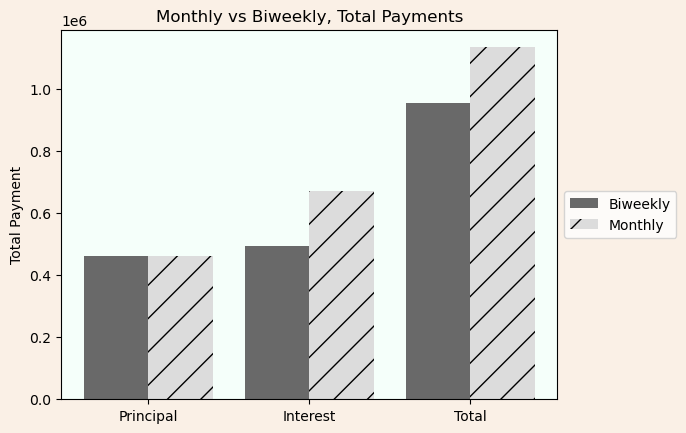

In [14]:
#bar chart to pair with the previous chart showing totals
#get the totals
x=np.arange(3)
width=.4
monthly_totals = [np.sum(merged_df['Principal_x'] + merged_df['Additional_Principal_x']), np.sum(merged_df['Interest_x']), np.sum(merged_df['Principal_x'] + merged_df['Additional_Principal_x'] + merged_df['Interest_x'])]
biweekly_totals = [np.sum(merged_df['Principal_y'] + merged_df['Additional_Principal_y']), np.sum(merged_df['Interest_y']), np.sum(merged_df['Principal_y'] + merged_df['Additional_Principal_y'] + merged_df['Interest_y'])]
#plot the pseudo grouped bar chart
fig, ax = plt.subplots(facecolor='linen')
plt.bar(x-.2, biweekly_totals, width, color='dimgrey')
plt.bar(x+.2, monthly_totals, width, color='gainsboro', hatch='/')
plt.xticks(x, ['Principal', 'Interest', 'Total'])
ax.set_facecolor('mintcream')
plt.ylabel('Total Payment')
plt.title('Monthly vs Biweekly, Total Payments')
ax.legend(['Biweekly','Monthly'], loc='center left', bbox_to_anchor = (1,.5))
plt.show()

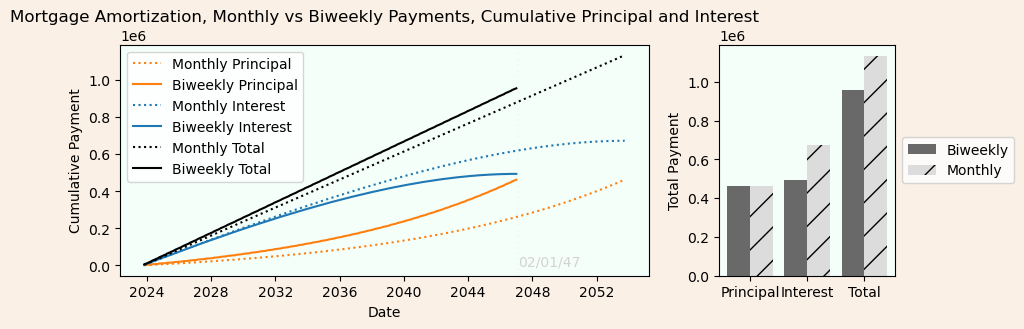

In [15]:
#ok last thing, put the previous two charts together in one image
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, facecolor='linen')

ax1.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_x'] + merged_df['Additional_Principal_x']), color='tab:orange', linestyle='dotted')
ax1.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_y'] + merged_df['Additional_Principal_y']), color='tab:orange')
ax1.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Interest_x']), color='tab:blue', linestyle='dotted')
ax1.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Interest_y']), color='tab:blue')
ax1.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_x'] + merged_df['Additional_Principal_x'] + merged_df['Interest_x']), color='black', linestyle='dotted')
ax1.plot(merged_df['Compound_Date'], np.cumsum(merged_df['Principal_y'] + merged_df['Additional_Principal_y'] + merged_df['Interest_y']), color='black')
ax1.set_facecolor('mintcream')
ax1.axvline(merged_df.loc[merged_df['Principal_y'].isnull().idxmax(), 'Compound_Date'], color='lightgrey', linestyle=':', alpha=.1)
ax1.annotate(text=merged_df.loc[merged_df['Principal_y'].isnull().idxmax(), 'Compound_Date'].strftime("%x"),
             xy=[merged_df.loc[merged_df['Principal_y'].isnull().idxmax(), 'Compound_Date'], 100], #i don't think this will work right at full size
             color='lightgrey')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Payment')
ax1.set_title('Mortgage Amortization, Monthly vs Biweekly Payments, Cumulative Principal and Interest')
ax1.legend(['Monthly Principal', 'Biweekly Principal', 'Monthly Interest', 'Biweekly Interest', 'Monthly Total', 'Biweekly Total'], loc='upper left')

x=np.arange(3)
width=.4
monthly_totals = [np.sum(merged_df['Principal_x'] + merged_df['Additional_Principal_x']), np.sum(merged_df['Interest_x']), np.sum(merged_df['Principal_x'] + merged_df['Additional_Principal_x'] + merged_df['Interest_x'])]
biweekly_totals = [np.sum(merged_df['Principal_y'] + merged_df['Additional_Principal_y']), np.sum(merged_df['Interest_y']), np.sum(merged_df['Principal_y'] + merged_df['Additional_Principal_y'] + merged_df['Interest_y'])]
#plot the pseudo grouped bar chart
ax2.bar(x-.2, biweekly_totals, width, color='dimgrey')
ax2.bar(x+.2, monthly_totals, width, color='gainsboro', hatch='/')
ax2.set_xticks(x, ['Principal', 'Interest', 'Total'])
ax2.set_facecolor('mintcream')
ax2.set_ylabel('Total Payment')
#ax2.set_title('Monthly vs Biweekly, Total Payments')
ax2.legend(['Biweekly','Monthly'], loc='center left', bbox_to_anchor = (1,.5))

#fig.tight_layout()
#fig.savefig('grid_figure.pdf')
fig.set_size_inches(10,3)
plt.show()